# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [134]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = "SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"

OPEN_SANS_BOLD = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"
OPEN_SANS_LIGHT = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf"

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

# Generate Function

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
generate_squares(3)

<generator object generate_squares at 0x0000020A03DE9510>

In [8]:
for i in generate_squares(5):
    print(i, end=" ->")

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body
        

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

spam_emails.head()

C:\Users\fatima\AppData\Local\Temp\ipykernel_8720\3820077146.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()

C:\Users\fatima\AppData\Local\Temp\ipykernel_8720\1749669298.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [14]:
ham_emails.shape

(3901, 2)

In [15]:
data = pd.concat([spam_emails, ham_emails])
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [16]:
data.shape

(5799, 2)

In [17]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [18]:
# check if any messages bodies are null
data['MESSAGE'].isnull().values.any()

False

In [19]:
# check if there are empty emails (string length zero)
(data['MESSAGE'].str.len() == 0).any()

True

In [20]:
(data['MESSAGE'].str.len() == 0).sum()

3

In [21]:
data['MESSAGE'].isnull().values.sum()

0

### Locate empty emails

In [22]:
data[data['MESSAGE'].str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [23]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from Dataframe

In [24]:
data.drop(['cmds'], inplace=True)

In [25]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [26]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [27]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True) 
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save to File using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [30]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

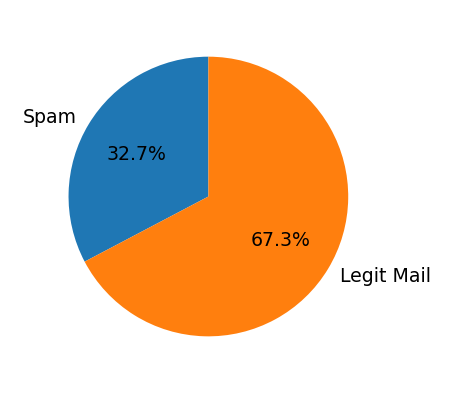

In [32]:
categoty_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%')
plt.show()

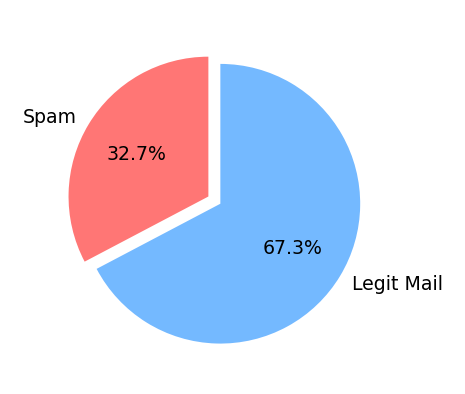

In [33]:
categoty_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

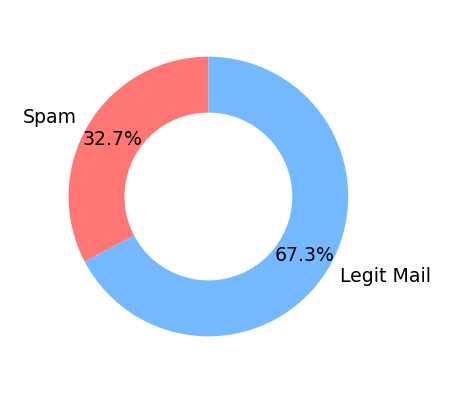

In [34]:
categoty_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

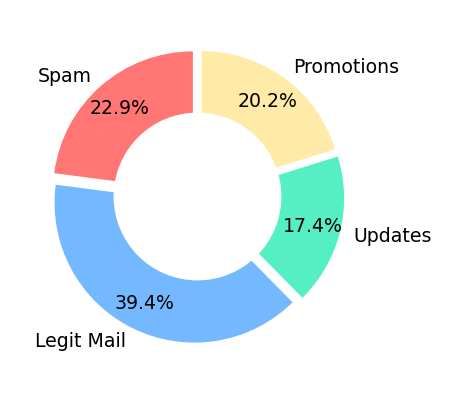

In [35]:
categoty_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Languages Processing

### Text pre-Processing

### Download the NLTK Resources (Tokenizer & Stopwords)

In [36]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\fatima\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\fatima\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [39]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [40]:
stop_words = set(stopwords.words('english'))

In [41]:
type(stop_words)

set

In [42]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = [word for word in words if word not in stop_words]
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

## Word Stems and Stemming

In [43]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 'nobodi',
 'expect',
 'spanish',
 'inquisit',
 '!']

## Removing Punctuation

In [44]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 'nobodi',
 'expect',
 'spanish',
 'inquisit']

## Removing HTML tags from Emails

In [45]:
soup = BeautifulSoup(data.at[7, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
  <title>
   ReliaQuote - Save Up To 70% On Life Insurance
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 </head>
 <body alink="#FFCC00" leftmargin="0" link="#FFCC99" topmargin="0" vlink="#FFCC99">
  <table align="center" bgcolor="993366" border="0" cellpadding="0" cellspacing="0" height="500" width="468">
   <tr>
    <td align="left" height="43" valign="top" width="56%">
     <table border="0" cellpadding="3" cellspacing="0" width="100%">
      <tr>
       <td>
        <a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&amp;ext=1" target="_blank">
         <img border="0" height="32" src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120"/>
        </a>
       </td>
      </tr>
     </table>
    </td>
    <td align="left" height="43" valign="top" width="44%">
    </td>
   </tr>
   <tr>
    <td align="left" height="377" valign="top" width="56%">
     <table border="0" cellpadding="0" cellspacing="0" 

In [46]:
soup.get_text()

"\n\nReliaQuote - Save Up To 70% On Life Insurance\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLife\n\n                                can change in an instant. That's why it is so\n\n                                important to protect your family's financial future\n\n                                with sufficient life insurance coverage.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nState\n\n                          of Residence:\n\n\n\nSelect State\nAlabama\nAlaska\nArizona\nArkansas\nCalifornia\nColorado\nConnecticut\nDelaware\nDist. of Columbia\nFlorida\nGeorgia\nHawaii\nIdaho\nIllinois\nIndiana\nIowa\nKansas\nKentucky\nLouisiana\nMaine\nMaryland\nMassachusetts\nMichigan\nMinnesota\nMississippi\nMissouri\nMontana\nNebraska\nNevada\nNew Hampshire\nNew Jersey\nNew Mexico\nNew York\nNorth Carolina\nNorth Dakota\nOhio\nOklahoma\nOregon\nPennsylvania\nRhode Island\nSouth Carolina\nSouth Dakota\nTennessee\nTexas\nUtah\nVermont\nVirginia\nWashington\nWest V

## Functions for Email Processing

In [47]:
def clean_message(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    # Convers to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [48]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [49]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Convers to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [50]:
clean_msg_no_html(data.at[7, 'MESSAGE'])

['reliaquot',
 'save',
 'life',
 'insur',
 'life',
 'chang',
 'instant',
 'import',
 'protect',
 'famili',
 'financi',
 'futur',
 'suffici',
 'life',
 'insur',
 'coverag',
 'state',
 'resid',
 'select',
 'state',
 'alabama',
 'alaska',
 'arizona',
 'arkansa',
 'california',
 'colorado',
 'connecticut',
 'delawar',
 'dist',
 'columbia',
 'florida',
 'georgia',
 'hawaii',
 'idaho',
 'illinoi',
 'indiana',
 'iowa',
 'kansa',
 'kentucki',
 'louisiana',
 'main',
 'maryland',
 'massachusett',
 'michigan',
 'minnesota',
 'mississippi',
 'missouri',
 'montana',
 'nebraska',
 'nevada',
 'new',
 'hampshir',
 'new',
 'jersey',
 'new',
 'mexico',
 'new',
 'york',
 'north',
 'carolina',
 'north',
 'dakota',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'rhode',
 'island',
 'south',
 'carolina',
 'south',
 'dakota',
 'tennesse',
 'texa',
 'utah',
 'vermont',
 'virginia',
 'washington',
 'west',
 'virginia',
 'wisconsin',
 'wyom',
 'date',
 'birth',
 'mm',
 'dd',
 'yy',
 'sex',
 'male',
 'femal'

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [51]:
data.iat[7, 2]

'00008.dfd941deb10f5eed78b1594b131c9266'

In [52]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [53]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [54]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

321

In [55]:
%%time

# use apply() on all the messages in the dataframe)
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\fatima\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\fatima\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 37.6 s


In [56]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [57]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [58]:
data[data.CATEGORY == 1].head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [59]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
1894,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
1895,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [60]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [61]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [62]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [63]:
type(nested_list)

pandas.core.series.Series

In [64]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [65]:
nested_list_ham.shape

(3900,)

In [66]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [67]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [68]:
nested_list_spam.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [69]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

In [70]:
normal_words.shape[0] # total number of unique words in the non-spam messages

20814

In [71]:
spammy_words.shape[0] # total number of unique words in the spam messages

13241

In [72]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [73]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

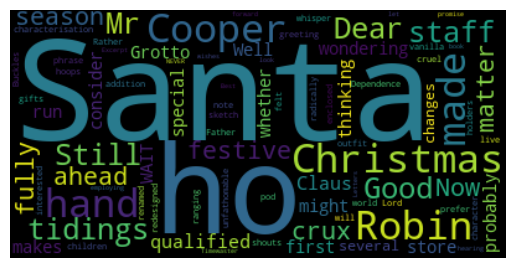

In [74]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [75]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [76]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [77]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [78]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

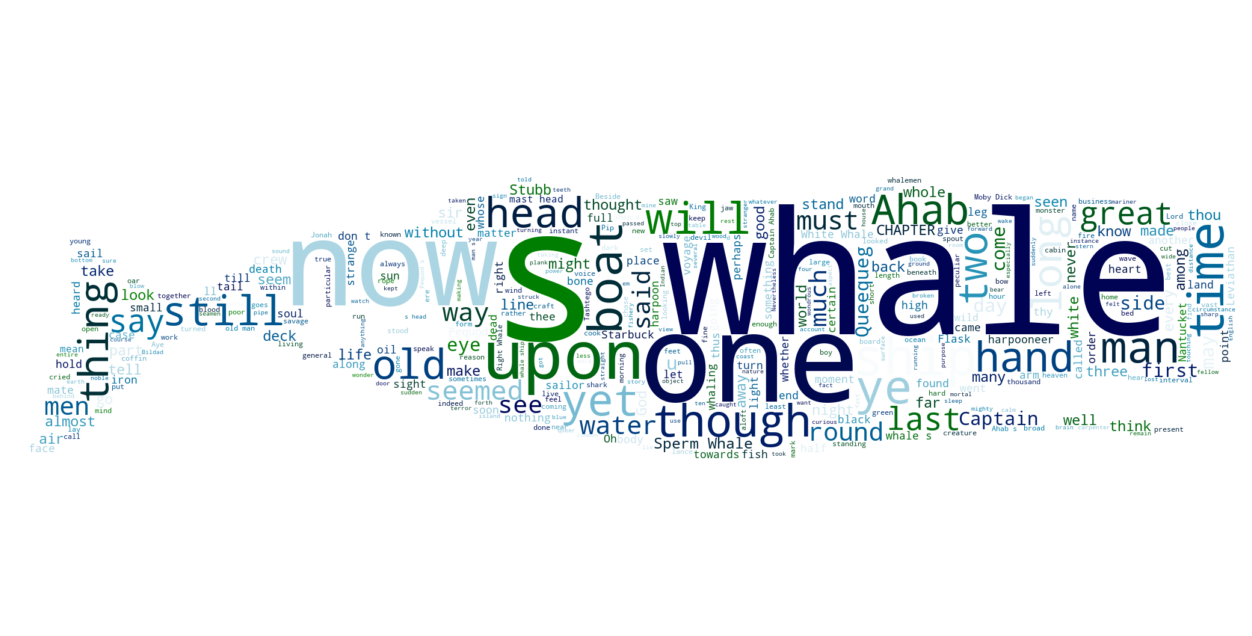

In [79]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [80]:
rgb_array.shape

(1024, 2048, 3)

In [81]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [82]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

## Hamlet Challenge

In [83]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

hamlet_list = [''.join(item) for item in hamlet_corpus]
novel_as_string = ' '.join(hamlet_list) 

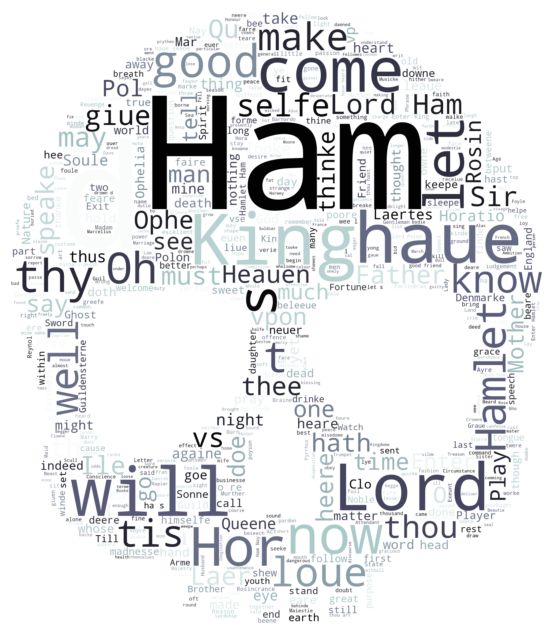

In [84]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=600, colormap='bone')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

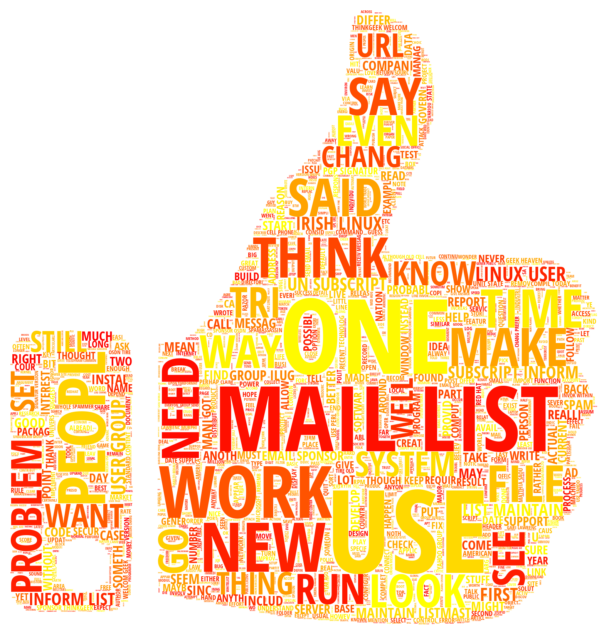

In [85]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the Word Cloud
ham_str = ' '.join(flat_list_ham)


word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='autumn', font_path=OPEN_SANS_BOLD)

word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

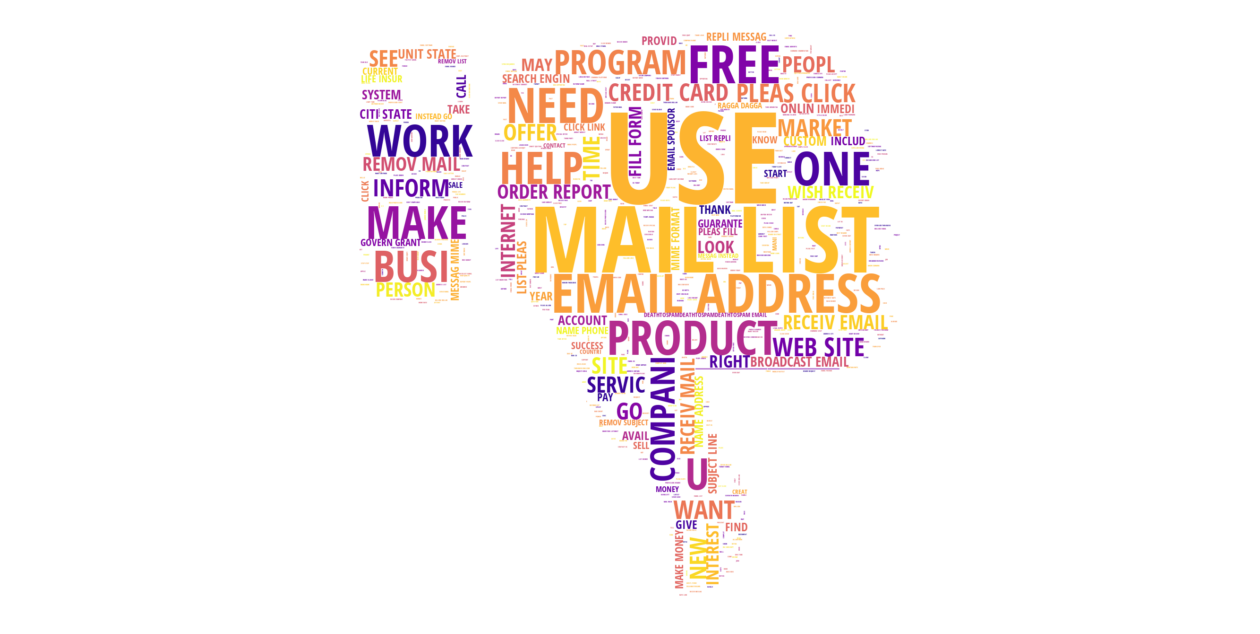

In [86]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the Word Cloud
spam_str = ' '.join(flat_list_spam)


word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=600, colormap='plasma', font_path=OPEN_SANS_BOLD)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [87]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\fatima\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\fatima\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [88]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of Unique Words', unique_words.shape[0])
unique_words.head()

Nr of Unique Words 27332


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [89]:
frequent_words = unique_words[0:VOCAB_SIZE]
frequent_words[:10]

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

## Create Vocabulary DataFrame with a WORD_ID

In [90]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [91]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [92]:
any(vocab.VOCAB_WORD == 'app') # Inefficient

True

In [93]:
'brewery' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [94]:
# Python List Comprehension
len_list = [len(stemmed_nested_list.values[position]) for position 
            in range(0, len(stemmed_nested_list))]
print(max(len_list))

7671


In [95]:
print('Email position in the list (and the data dataframe)', np.argmax(len_list))

Email position in the list (and the data dataframe) 5775


In [96]:
stemmed_nested_list[np.argmax(len_list)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [97]:
data.at[np.argmax(len_list), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [98]:
type(stemmed_nested_list)

pandas.core.series.Series

In [99]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [100]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [101]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, 
                                                    test_size=0.3, random_state=42)

In [102]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [103]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [104]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [105]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [106]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [107]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'fashion', 'invalid', 'raid', 'distributor', 'tobacco', 'till', 'corn',
       'analog', 'apach', 'overnight'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [108]:
word_index.get_loc('thu')

393

In [109]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [110]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 7min 7s


In [111]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1239
2,0,4844,1,504
3,0,4844,1,308
4,0,4844,1,254


In [112]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429179,1,860,1,47
429180,1,860,1,1431
429181,1,860,1,26
429182,1,860,1,21
429183,1,860,1,126


In [113]:
sparse_train_df.shape

(429184, 4)

### Combine Occurrences with Pandas groupby() Method

In [114]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [115]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [116]:
data.MESSAGE[7]

'<html>\n\n<head>\n\n<title>ReliaQuote - Save Up To 70% On Life Insurance</title>\n\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1">\n\n</head>\n\n<body leftmargin="0" topmargin="0" link="#FFCC99" vlink="#FFCC99" alink="#FFCC00">\n\n<table align="center" width="468" border="0" cellspacing="0" cellpadding="0" height="500" bgcolor="993366">\n\n  <tr>\n\n    <td align="left" valign="top" height="43" width="56%">\n\n      <table width="100%" border="0" cellspacing="0" cellpadding="3">\n\n        <tr>\n\n          <td><a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&ext=1" target="_blank"><img src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120" height="32" border="0"></a></td>\n\n        </tr>\n\n      </table>\n\n    </td>\n\n    <td align="left" valign="top" height="43" width="44%">&nbsp;</td>\n\n  </tr>\n\n  <tr>\n\n    <td align="left" valign="top" width="56%" height="377">\n\n      <table width="100%" border="0" cellsp

In [117]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [118]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258327,5795,2032,0,2
258328,5795,2037,0,1
258329,5795,2271,0,1
258330,5795,2348,0,1
258331,5795,2379,0,1


In [119]:
vocab.at[2032, 'VOCAB_WORD']

'swap'

In [120]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [121]:
train_grouped.shape

(258332, 4)

### Save Training Data as .txt File

In [123]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [124]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

### Test Data

In [127]:
%%time

# Create a Sparse Matrix for the Test Data

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 3min 28s


In [128]:
sparse_test_df.shape

(203404, 4)

In [129]:
# Combine Occurrences with Pandas groupby() Method

test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      2       1              1
       3       1              4
       4       1              2
       5       1              1
       6       1              2

In [130]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [131]:
vocab.at[3, 'VOCAB_WORD']

'email'

In [132]:
data.MESSAGE[8]

'TIRED OF THE BULL OUT THERE?\n\nWant To Stop Losing Money?\n\n\n\nWANT A REAL MONEY MAKER?\n\nRECEIVE $1,000-$5,000 TODAY!\n\nEXPERTS ARE CALLING THIS THE FASTEST WAY TO HUGE CASH FLOW EVER CONCEIVED!\n\n\n\nA POWERHOUSE Gifting Program You Don\'t Want To Miss!\n\nWe work as a TEAM! \n\n\n\nThis is YOUR Private Invitation GET IN WITH THE FOUNDERS! This is where the BIG BOYS PLAY! The MAJOR PLAYERS are on This ONE For ONCE be where the Players are\n\n\n\nThis is a system that will drive $1,000\'s to your doorstep \n\nIn a short period of time!\n\n\n\nLeverage $1000.00 into $50,000, Over and Over Again \n\n\n\nTHE QUESTION HERE IS:\n\n\n\nYOU EITHER WANT TO BE WEALTHY OR YOU DON\'T!!!\n\n\n\nWHICH ONE ARE YOU?\n\n\n\nI am tossing you a financial lifeline and for your sake I \n\n\n\nHope you GRAB onto it and hold on tight For the Ride of your life!\n\n\n\nTestimonials\n\n\n\nHear what average people are doing their first few days:\n\n\x93We\'ve received 8,000 in 1 day and we are doing th

In [133]:
test_grouped.shape

(117774, 4)

In [135]:
# Save Test Data as .txt File

np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [139]:
test_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [143]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [144]:
len(train_doc_ids)

4013

In [145]:
len(test_doc_ids)

1724

In [147]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [150]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG

In [152]:
data.loc[134]

MESSAGE      ------=_NextPart_000_00E8_85C13B1D.B7243B86\n\...
CATEGORY                                                     1
FILE_NAME               00135.00e388e3b23df6278a8845047ca25160
Name: 134, dtype: object

In [153]:
clean_msg_no_html(data.at[134, 'MESSAGE'])

[]